In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import FinancialMachineLearning as fml

### Chapter 7. Cross-Validation in Finance

#### Exercise 1

금융에 있어서 K-Fold Cross Validation을 수행하기 전에 데이터셋을 섞는 것이 일반적으로 좋지 않은 이유는 무엇인가?데이터를 Shuffling하는 목적은 무엇인가? 데이터를 Shuffling하면 금융 데이터셋에 있어 K-Fold Cross Validation의 목적이 무의미해지는 이유는 무엇인가?

답 : 우리가 사용하는 금융 시계열 데이터셋인데, 만약 데이터셋을 섞게 된다면 순차적 시간 정보다 뒤섞이게 된다. 이는 오히려 추정기의 성능을 떨어뜨리는 결과를 낳게 된다. 일반적으로 Data Science 분야에서 교차 검증을 위해 데이터를 섞는 이유는 무작위 표본 추출로 test, validation, train set을 선택하기 위함인데, 금융 시계열 데이터에서는 Shuffling을 한다면 시간 정보가 사라지고, information leak 등의 다양한 문제가 발생하게 되어 결과적으로 목적이 무의미해진다.

#### Exercise 2

관측된 특성과 레이블로 구성된 한 쌍의 행렬$(X,y)$을 하나 구하자. 3장 연습 문제에서 도출한 데이터셋 중 하나를 사용해도 된다.

In [2]:
df = pd.read_csv('sp500featureBin.csv')
df

,Unnamed: 0,dollar,frac_diff_dollar,tW,w,bin
0,2009-11-04 14:41:43,50.4500,0.529761,0.750000,1.984399,-1.0
1,2009-11-04 15:43:57,49.8800,-0.137134,0.444444,0.077423,1.0
2,2009-11-05 09:46:35,50.2080,0.349295,0.388889,3.523273,1.0
3,2009-11-06 10:39:27,50.5448,0.038635,0.333333,3.626638,1.0
4,2009-11-06 12:37:18,50.9232,0.559177,0.333333,2.644159,1.0
...,...,...,...,...,...,...
3467,2018-09-26 10:07:41,116.5780,0.334817,0.209694,0.813016,-1.0
3468,2018-09-26 15:47:29,115.9960,0.220088,0.189087,0.495700,1.0
3469,2018-09-27 10:02:15,116.1100,0.750801,0.176905,0.055908,-1.0
3470,2018-09-27 15:39:35,115.9000,0.349971,0.166905,0.621259,1.0


In [3]:
X = df.iloc[:,:-1].values # dollar, frac_diff, tW, w
y = df.iloc[:,-1].values.reshape(-1,1) # bin

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, random_state = 42)

**(a)** $(X,y)$에 대해 데이터를 Shuffling하지 않고 Random Forest Classifier의 10 Fold Cross Validation의 성능을 도출해 보라

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train.reshape(1,-1))
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train.reshape(-1,))

In [6]:
cweight = pd.DataFrame()
cweight.index = df.index
cweight['class_weight'] = np.nan
cweight.loc[df[df.bin == -1.0].index] = weights[1]
cweight.loc[df[df.bin == 1.0].index] = weights[0]
cweight

,class_weight
0,0.888158
1,1.144068
2,1.144068
3,1.144068
4,1.144068
...,...
3467,0.888158
3468,1.144068
3469,0.888158
3470,1.144068


In [7]:
#based on book recommendation
rf = RandomForestClassifier(n_estimators = 1000, criterion = "entropy", bootstrap = True,
                                n_jobs=1, random_state=42, class_weight = 'balanced_subsample', oob_score=False)
cv_gen = KFold(n_splits = 10, shuffle = False)
score = fml.cvScore(rf, X, y, sample_weight = cweight, scoring = 'neg_log_loss', cv = None, cvGen = cv_gen, pctEmbargo = 0)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.717943
CV Variance: 0.006818


**(b)** $(X,y)$에 대해 데이터를 섞으며 Random Forest Classifier의 10 Fold Cross Validation의 검증 성능을 도출해 보라

In [8]:
cv_gen0 = KFold(n_splits = 10, random_state = 42, shuffle = True)

score = fml.cvScore(rf, X, y, sample_weight = cweight, scoring = 'neg_log_loss', cv = None, cvGen = cv_gen0, pctEmbargo = 0)
print('rf_clf Mean CV score: {0:.6f}\nCV Variance: {1:.6f}'.format(score.mean(), score.var()))

rf_clf Mean CV score: -0.556278
CV Variance: 0.000234


**(c)** 두 결과가 많이 다른 이유는 무엇인가?

**(d)** 데이터를 Shuffling하면 Information Leak이 어떻게 일어나는가?

#### Exercise 3
Exercise 2에서 사용한 것과 동일한 $(X,y)$행렬을 사용하자

**(a)** $(X,y)$에 대해 1% Embargo를 사용한 Random Forest Classifier의 10 Fold Purged Cross Validation의 검증 성능을 도출해 보라

In [9]:
df = pd.read_parquet('./Data/IVE_tickbidask.parq')
mad = fml.madOutlier(df.price.values.reshape(-1, 1))
df = df.loc[~mad]
df

86.96
[36.17 36.25 36.21 ... 29.26 29.26 29.26]
[1.41225268 1.41537627 1.41381447 ... 1.14245268 1.14245268 1.14245268]


,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2018-10-05 15:59:59,116.20,116.18,116.19,2000,2000,232400.00
2018-10-05 15:59:59,116.20,116.18,116.19,3900,3900,453180.00
2018-10-05 16:00:00,116.22,116.20,116.21,42884,42884,4983978.48


In [10]:
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)
dollar_df = dollar_df.groupby(level = 0).first()
dollar_df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:46:35,51.07,51.05,51.07,900,900,45963.00
2009-09-28 09:53:49,51.14,51.13,51.14,2000,2000,102280.00
2009-09-28 09:55:26,51.14,51.11,51.14,100,100,5114.00
2009-09-28 10:02:52,51.25,51.24,51.26,4300,4300,220375.00
2009-09-28 10:10:21,51.29,51.28,51.29,4500,4500,230805.00
...,...,...,...,...,...,...
2018-10-05 15:58:23,116.19,116.19,116.20,1354,1354,157321.26
2018-10-05 15:59:20,116.18,116.17,116.19,300,300,34854.00
2018-10-05 15:59:55,116.19,116.18,116.20,800,800,92952.00


In [11]:
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)
dollar_df = dollar_df.groupby(level = 0).first()
dollar_df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:46:35,51.07,51.05,51.07,900,900,45963.00
2009-09-28 09:53:49,51.14,51.13,51.14,2000,2000,102280.00
2009-09-28 09:55:26,51.14,51.11,51.14,100,100,5114.00
2009-09-28 10:02:52,51.25,51.24,51.26,4300,4300,220375.00
2009-09-28 10:10:21,51.29,51.28,51.29,4500,4500,230805.00
...,...,...,...,...,...,...
2018-10-05 15:58:23,116.19,116.19,116.20,1354,1354,157321.26
2018-10-05 15:59:20,116.18,116.17,116.19,300,300,34854.00
2018-10-05 15:59:55,116.19,116.18,116.20,800,800,92952.00


In [12]:
import statsmodels.api as sm

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 2, 21):
    try:
        df1 = np.log(dollar_df).resample('1H').last().dropna() # daily return
        df2 = fml.fracDiff(df1, d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index, 'price'], df2['price'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['price'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {d.round(1)}, error: {e}')
        continue

,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-1.092230,7.181607e-01,1.0,16056.0,-2.861720,1.000000
0.1,-0.765815,8.289581e-01,1.0,5.0,-3.929280,0.977330
0.2,-1.799711,3.806051e-01,1.0,10.0,-3.232950,0.968024
0.3,-2.461093,1.252301e-01,1.0,22.0,-3.005426,0.924809
0.4,-3.784537,3.069540e-03,1.0,54.0,-2.916770,0.834352
0.5,-3.798314,2.924611e-03,1.0,140.0,-2.882416,0.626855
0.6,-8.670902,4.549392e-14,1.0,386.0,-2.869057,0.216403
0.7,-17.046703,8.124175e-30,1.0,1131.0,-2.864099,0.234206
0.8,-32.011251,0.000000e+00,1.0,3435.0,-2.862382,0.056763
0.9,-60.484925,0.000000e+00,1.0,9231.0,-2.861853,0.015171


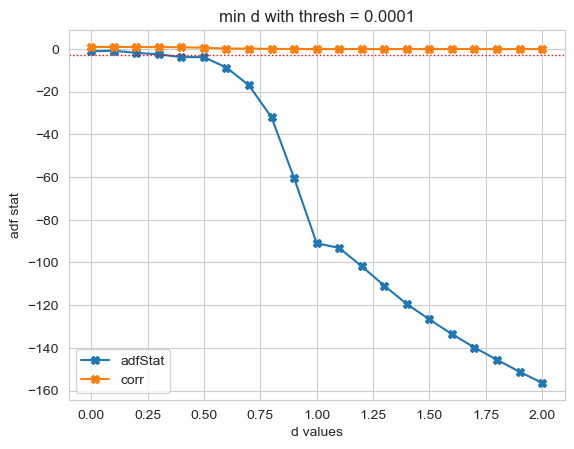

In [13]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = 'dotted')
ax.set_title('min d with thresh = 0.0001')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat')
display(out)

In [14]:
min_ffd = out[out.pVal <= 0.05].iloc[0].name
print("The min. D that makes the fracdiff stationary", min_ffd.round(1))

The min. D that makes the fracdiff stationary 0.4


In [15]:
dfx2 = fml.fracDiff_FFD(dollar_df, min_ffd, thres = 1e-5)
dfx2

,price,bid,ask,size,v,dv
2010-03-26 11:26:38,2.402175,2.405407,2.401254,-1566.097635,-1566.097635,-8.831668e+04
2010-03-26 12:19:32,2.260911,2.265738,2.272400,-635.282068,-635.282068,-3.554943e+04
2010-03-26 13:17:41,1.878234,1.862878,1.866037,-820.485053,-820.485053,-4.616751e+04
2010-03-26 14:06:01,2.033713,2.049451,2.041749,-563.673663,-563.673663,-3.159842e+04
2010-03-26 14:53:39,2.227545,2.238243,2.234149,3450.070546,3450.070546,1.949670e+05
...,...,...,...,...,...,...
2018-10-05 15:58:23,4.170953,4.177816,4.178052,60.589562,60.589562,6.770713e+03
2018-10-05 15:59:20,4.177320,4.170712,4.180933,-1138.121955,-1138.121955,-1.324908e+05
2018-10-05 15:59:55,4.195012,4.191535,4.197745,-267.716498,-267.716498,-3.134789e+04
2018-10-05 15:59:59,4.203792,4.191106,4.186107,831.328289,831.328289,9.637337e+04


In [16]:
tEvents = fml.getTEvents(dfx2.price, h = dfx2.std().iat[0] * 2)
tEvents

DatetimeIndex(['2010-05-06 14:11:07', '2010-05-06 14:46:18',
               '2010-05-06 14:49:50', '2010-05-06 14:54:16',
               '2010-05-06 15:00:56', '2010-05-06 15:04:56',
               '2010-05-06 15:10:40', '2010-05-10 10:37:07',
               '2010-05-20 10:25:00', '2010-05-21 09:56:55',
               ...
               '2018-03-19 13:27:36', '2018-03-22 12:18:06',
               '2018-03-27 15:33:33', '2018-04-04 10:49:16',
               '2018-04-20 11:11:15', '2018-05-03 10:26:55',
               '2018-05-10 09:43:36', '2018-05-29 12:22:34',
               '2018-06-07 09:49:34', '2018-07-26 09:42:41'],
              dtype='datetime64[ns]', length=158, freq=None)

In [17]:
dollar_feature = dollar_df.price.loc[tEvents]
dollar_feature

2010-05-06 14:11:07     55.2200
2010-05-06 14:46:18     50.8500
2010-05-06 14:49:50     37.0300
2010-05-06 14:54:16     48.5800
2010-05-06 15:00:56     50.6800
                         ...   
2018-05-03 10:26:55    107.2500
2018-05-10 09:43:36    110.7900
2018-05-29 12:22:34    109.1457
2018-06-07 09:49:34    112.7000
2018-07-26 09:42:41    114.3267
Name: price, Length: 158, dtype: float64

In [18]:
frac_diff_feature = dfx2.loc[tEvents]
frac_diff_feature

,price,bid,ask,size,v,dv
2010-05-06 14:11:07,1.347537,1.353610,1.351482,-2940.217001,-2940.217001,-1.648082e+05
2010-05-06 14:46:18,-1.797735,-1.724229,-0.803539,-930.450315,-930.450315,-5.414868e+04
2010-05-06 14:49:50,-14.397046,-16.283858,-14.749441,-886.952647,-886.952647,-5.726046e+04
2010-05-06 14:54:16,3.080064,-14.722817,7.959214,-1181.398893,-1181.398893,-6.358208e+04
2010-05-06 15:00:56,0.503087,3.535875,-0.533802,-56.007943,-56.007943,-7.765767e+03
...,...,...,...,...,...,...
2018-05-03 10:26:55,3.057498,3.076488,3.071800,-1654.096090,-1654.096090,-1.798094e+05
2018-05-10 09:43:36,4.647842,9.076208,3.583460,-15495.995012,-15495.995012,-1.704916e+06
2018-05-29 12:22:34,3.192796,3.193470,3.190242,-405.865210,-405.865210,-4.563728e+04
2018-06-07 09:49:34,4.754790,4.732923,4.746667,9545.038853,9545.038853,1.077384e+06


In [19]:
feature_Mat = (pd.DataFrame().assign(dollar = dollar_feature, frac_diff_dollar = frac_diff_feature.price).drop_duplicates().dropna())
feature_Mat

,dollar,frac_diff_dollar
2010-05-06 14:11:07,55.2200,1.347537
2010-05-06 14:46:18,50.8500,-1.797735
2010-05-06 14:49:50,37.0300,-14.397046
2010-05-06 14:54:16,48.5800,3.080064
2010-05-06 15:00:56,50.6800,0.503087
...,...,...
2018-05-03 10:26:55,107.2500,3.057498
2018-05-10 09:43:36,110.7900,4.647842
2018-05-29 12:22:34,109.1457,3.192796
2018-06-07 09:49:34,112.7000,4.754790


In [20]:
dailyVol = fml.getDailyVolatility(feature_Mat.dollar)
dailyVol

2010-05-10 10:37:07         NaN
2010-05-20 10:25:00    0.066881
2010-05-21 09:56:55    0.055235
2010-05-25 11:59:59    0.045770
2010-06-08 10:45:25    0.040127
                         ...   
2018-05-03 10:26:55    0.036843
2018-05-10 09:43:36    0.036777
2018-05-29 12:22:34    0.036453
2018-06-07 09:49:34    0.036379
2018-07-26 09:42:41    0.036054
Name: dailyVol, Length: 151, dtype: float64

In [21]:
t1 = fml.addVerticalBarrier(tEvents, feature_Mat.dollar, numDays = 5)
t1

2010-05-06 14:11:07   2010-05-20 10:25:00
2010-05-06 14:46:18   2010-05-20 10:25:00
2010-05-06 14:49:50   2010-05-20 10:25:00
2010-05-06 14:54:16   2010-05-20 10:25:00
2010-05-06 15:00:56   2010-05-20 10:25:00
                              ...        
2018-04-20 11:11:15   2018-05-03 10:26:55
2018-05-03 10:26:55   2018-05-10 09:43:36
2018-05-10 09:43:36   2018-05-29 12:22:34
2018-05-29 12:22:34   2018-06-07 09:49:34
2018-06-07 09:49:34   2018-07-26 09:42:41
Length: 157, dtype: datetime64[ns]

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn import metrics
from scipy import interp

scoreVal plot : BlackArbsCEO

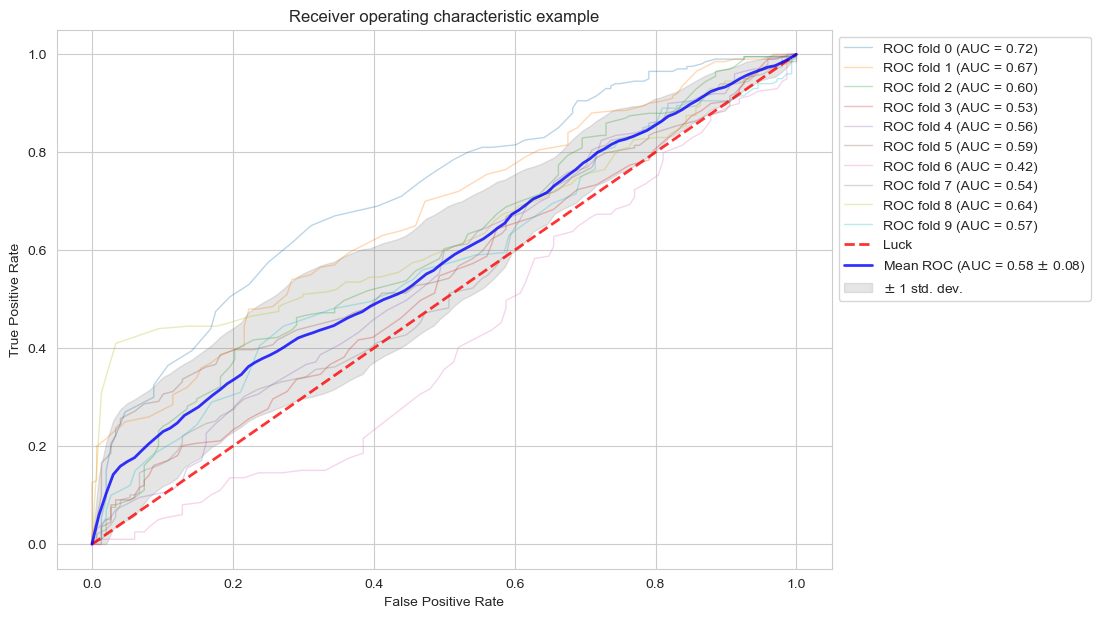

In [23]:
skf = StratifiedKFold(n_splits=10, shuffle = False)
classifier = RandomForestClassifier(n_estimators = 100, criterion='entropy', class_weight='balanced_subsample', random_state = 42)
fml.crossValPlot(skf, classifier, X,y)

rf_clf Mean CV score: -0.556278
CV Variance: 0.000234
